In [1]:
import pickle
import sys

sys.path.append("/home/cctrotte/krauthammer/eustar/benchmark_VAE/src/")
sys.path.append("/cluster/work/medinfmk/EUSTAR2/code_ct/benchmark_VAE/src/")

from pythae.data.datasets import MissingDataset

from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models import BetaVAEgp, BetaVAEgpCondInd, BetaVAEgpPrior, BetaVAEgpPost
from pythae.models import (
    BetaVAEgpConfig,
    BetaVAEgpCondIndConfig,
    BetaVAEgpPriorConfig,
    BetaVAEgpPostConfig,
)
from pythae.models.beta_vae_gp.GP import predict_D, predict_D2
from pythae.models.beta_vae_gp.encoder_decoder import (
    Indep_MLP_Encoder,
    Indep_MLP_Decoder,
    Guidance_Classifier,
    MLP_Predictor,
    LSTM_Predictor,
    LSTM_Encoder,
    LSTM_Decoder,
    LSTM_Retrodiction_Encoder,
    LSTM_Retrodiction_Decoder,
)
from pythae.models import AutoModel
from pythae.models.beta_vae_gp.utils import (
    load_missing_data_train_test,
    get_classifier_config,
)
from pythae.models.beta_vae_gp.body import Body
from pythae.models.beta_vae_gp.classifier_config import (
    ClassifierConfig,
    PredictorConfig,
    EncoderDecoderConfig,
    PriorLatentConfig,
)
from pythae.models.beta_vae_gp.prior_latent import PriorLatent
from pythae.config import BaseConfig
import numpy as np
import torch
import random
import os
from pythae.models.beta_vae_gp.plots import plot_losses
import pandas as pd
from pythae.models.beta_vae_gp.plots import plot_losses, plot_recon_losses


In [2]:
 seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
local = True
device = "cuda" if torch.cuda.is_available() else "cpu"
if local:
    data_path = "/home/cctrotte/krauthammer/eustar/fake_data/processed/"
else:
    data_path = "/cluster/work/medinfmk/EUSTAR2/data/processed/ct/"

#name = "_reduced"
name = "_all"
with open(data_path + "body_" + name + ".pkl", "rb") as file:
    body = pickle.load(file)
with open(data_path + "cohort_" + name + ".pkl", "rb") as file:
    cohort = pickle.load(file)

(
    data_train,
    data_test,
    varNames,
    varSplits,
    xyt0,
    xyt1,
) = load_missing_data_train_test(data_path, name=name)
var_names0 = [var.name for var in (body.variables + body.labels)]

names_x0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "x"]
names_y0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "y"]

kinds_x0 = [
    var.kind
    for var in (body.variables + body.labels)
    for nx in names_x0
    if var.name == nx
]
kinds_y0 = [
    var.kind
    for var in (body.variables + body.labels)
    for nx in names_y0
    if var.name == nx
]
splits_x0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "x"]
splits_y0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "y"]
splits_s0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "s"]
# remove samples of length 0 or 1
data_train.list_x = [elem for elem in data_train.list_x if len(elem) >1]
data_train.list_y = [elem for elem in data_train.list_y if len(elem) >1]
data_train.list_t = [elem for elem in data_train.list_t if len(elem) >1]
data_train.list_s = [elem for elem in data_train.list_s if len(elem) >1]

data_train.missing_x = [elem for elem in data_train.missing_x if len(elem)> 1]
data_train.missing_y = [elem for elem in data_train.missing_y if len(elem)> 1]
data_train.missing_t = [elem for elem in data_train.missing_t if len(elem)> 1]
data_train.missing_s = [elem for elem in data_train.missing_s if len(elem)> 1]
data_test.list_x = [elem for elem in data_test.list_x if len(elem) >1]
data_test.list_y = [elem for elem in data_test.list_y if len(elem) >1]
data_test.list_t = [elem for elem in data_test.list_t if len(elem) >1]
data_test.list_s = [elem for elem in data_test.list_s if len(elem) >1]
data_test.missing_x = [elem for elem in data_test.missing_x if len(elem)> 1]
data_test.missing_y = [elem for elem in data_test.missing_y if len(elem)> 1]
data_test.missing_t = [elem for elem in data_test.missing_t if len(elem)> 1]
data_test.missing_s = [elem for elem in data_test.missing_s if len(elem)> 1]
input_size = sum(splits_x0)

static_size = sum(splits_s0)
latent_dim = 20
model_name = "VAE"

# to create classifier configs. Specify each classifier name, variables to predict in y, z dimensions to use and architecture of the classifier
classifier_config = {
    "lung_inv": {
        "y_names": ["LUNG_ILD_involvement_or"],
        "z_dims": np.arange(0, 2),
        "layers": [100],
        "type": "static",
    },
    "lung_stage": {
        "y_names": ["LUNG_ILD_stage_or"],
        "z_dims": np.arange(2, 4),
        "layers": [100],
        "type": "static",
    },
    "lung_fvc_prog": {
        "y_names": ["LUNG_ILD_FVC_progression"],
        "z_dims": np.arange(6, 8),
        "layers": [50],
        "type": "progression",
        "input_dim": 4,
    },
}
# weights for the different losses
beta = 0.01
# overall weight factor for the classifiers
w_class = {
    "lung_inv": 1,
    "lung_stage": 1,
    "lung_fvc_prog": 1,
}
# w_recon = max(0, 1 - beta - sum(w_class.values()))
w_recon = 1

# weights for the different losses
# beta_pred = 0.0
# overall weight factor for the classifiers
w_class_pred = {
    "lung_inv": 1,
    "lung_stage": 1,
    "lung_fvc_prog": 1,
}
# w_recon = max(0, 1 - beta - sum(w_class.values()))
w_recon_pred = 1

if w_recon == 0:
    print(f"reconstruction loss weight is 0")
classifier_configs = get_classifier_config(names_y0, splits_y0, classifier_config)
predict = True
retrodiction = True
encoder_config = EncoderDecoderConfig.from_dict({
    "input_dim": input_size + static_size,
    "output_dim": latent_dim,
    "latent_dim": latent_dim,
    "hidden_dims": [100, 100],
    "cond_dim_time_input": 1,
    "lstm_": True,
    "lstm_hidden_size": 50,
    "num_lstm_layers": 3,
    "device": device,
    "dropout": 0.2,
    "predict": predict,

})
decoder_config = EncoderDecoderConfig.from_dict({
    "latent_dim": latent_dim,
    "output_dim": input_size,
    "hidden_dims": [100,100],
    "cond_dim_time_latent": 1,
    "lstm_hidden_size": 50,
    "cond_dim_static_latent": static_size,
    "lstm_": False,
    "dropout": 0.2,
    "device": device,})

prior_config = PriorLatentConfig.from_dict({"input_dim": 1 + static_size, "latent_dim": latent_dim, "hidden_dims": [50], "device": device, "dropout": 0.1})
#prior_config = None
# decoder_config = EncoderDecoderConfig.from_dict({
#     "latent_dim": latent_dim,
#     "output_dim": input_size,
#     "hidden_dims": [100,],
#     "cond_dim_time_latent": 1,
#     "cond_dim_static_latent": static_size,
#     "lstm_": False,
#     "device": device,})

to_reconstruct_x = [(name, index, True) for index, name in enumerate(names_x0)]
# for index, elem in enumerate(kinds_x0):
#     if elem in ['categorical', 'binary']:
#         to_reconstruct_x[index] = (names_x0[index], index, False)
to_reconstruct_y = [(name, index, True) for index, name in enumerate(names_y0)]
model_config = BetaVAEgpCondIndConfig(
    input_dim=(input_size,),
    latent_dim=latent_dim,
    w_class=w_class,
    w_recon=w_recon,
    beta=beta,
    w_class_pred=w_class_pred,
    w_recon_pred=w_recon_pred,
    missing_loss=True,
    latent_prior_noise_var=1,
    classifier_config=classifier_configs,
    encoder_config = encoder_config,
    decoder_config = decoder_config,
    prior_config = prior_config,
    splits_x0=splits_x0,
    kinds_x0=kinds_x0,
    splits_y0=splits_y0,
    kinds_y0=kinds_y0,
    names_x0=names_x0,
    to_reconstruct_x = to_reconstruct_x,
    to_reconstruct_y = to_reconstruct_y,
    device=device,
    predict=predict,
    retrodiction = retrodiction,
    progression=False,
)

config = BaseTrainerConfig(
    output_dir="my_model",
    learning_rate=0.01,
    batch_size=1,
    num_epochs=6,  
    customized=True,  # if we use the cusomized data loader for different sized patients
)

if retrodiction:
    my_encoder = LSTM_Retrodiction_Encoder(encoder_config)
else: 
    my_encoder = LSTM_Encoder(encoder_config)
# my_encoder = Indep_MLP_Encoder(model_config)
if decoder_config.lstm_:
    my_decoder = LSTM_Retrodiction_Decoder(decoder_config)
else:
    my_decoder = Indep_MLP_Decoder(decoder_config)

if prior_config is not None:
    prior_latent = PriorLatent(prior_config)
else:
    prior_latent = None

my_classifiers = [
    Guidance_Classifier(config) for config in model_config.classifier_config
]
# my_classifier = Guidance_Classifier(model_config)

model = BetaVAEgpCondInd(
    model_config=model_config,
    encoder=my_encoder,
    decoder=my_decoder,
    classifiers=my_classifiers,
    prior_latent = prior_latent
)

pipeline = TrainingPipeline(training_config=config, model=model)
pipeline(train_data=data_train, eval_data=data_test)


Using customized Base Trainer

Model passed sanity check !

Created my_model/BetaVAEgpCondInd_training_2023-06-08_07-55-45. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/6:   0%|          | 0/559 [00:00<?, ?batch/s]

Eval of epoch 1/6:   0%|          | 0/187 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 4.577
Train losses: tensor([2.6976, 0.7941, 0.0255, 0.6267, 1.1766, 0.0747])
Train losses unw: tensor([5.2263, 0.7941, 2.5542, 0.6267, 1.1766, 0.0747])
Train losses pred: tensor([2.6735, 0.7940, 0.6273, 1.1774, 0.0747])
Train losses unw pred: tensor([2.6735, 0.7940, 0.6273, 1.1774, 0.0747])
Eval loss: 4.6769
Eval losses: tensor([2.7413, 0.7861, 0.0129, 0.6239, 1.2187, 0.0999])
Eval losses unw: tensor([4.0135, 0.7861, 1.2850, 0.6239, 1.2187, 0.0999])
Eval losses pred: tensor([2.7218, 0.7865, 0.6241, 1.2114, 0.0999])
Eval losses unw pred: tensor([2.7218, 0.7865, 0.6241, 1.2114, 0.0999])
--------------------------------------------------------------------------


Training of epoch 2/6:   0%|          | 0/559 [00:00<?, ?batch/s]

Eval of epoch 2/6:   0%|          | 0/187 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 4.5345
Train losses: tensor([2.6639, 0.7832, 0.0132, 0.6229, 1.1700, 0.0747])
Train losses unw: tensor([3.9663, 0.7832, 1.3156, 0.6229, 1.1700, 0.0747])
Train losses pred: tensor([2.6533, 0.7822, 0.6234, 1.1730, 0.0747])
Train losses unw pred: tensor([2.6533, 0.7822, 0.6234, 1.1730, 0.0747])
Eval loss: 4.6597
Eval losses: tensor([2.7272, 0.7868, 0.0037, 0.6235, 1.2133, 0.0999])
Eval losses unw: tensor([3.0936, 0.7868, 0.3701, 0.6235, 1.2133, 0.0999])
Eval losses pred: tensor([2.7192, 0.7866, 0.6233, 1.2094, 0.0999])
Eval losses unw pred: tensor([2.7192, 0.7866, 0.6233, 1.2094, 0.0999])
--------------------------------------------------------------------------


Training of epoch 3/6:   0%|          | 0/559 [00:00<?, ?batch/s]

Eval of epoch 3/6:   0%|          | 0/187 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 4.5202
Train losses: tensor([2.6551, 0.7829, 0.0085, 0.6217, 1.1674, 0.0747])
Train losses unw: tensor([3.4985, 0.7829, 0.8519, 0.6217, 1.1674, 0.0747])
Train losses pred: tensor([2.6474, 0.7818, 0.6223, 1.1685, 0.0747])
Train losses unw pred: tensor([2.6474, 0.7818, 0.6223, 1.1685, 0.0747])
Eval loss: 4.67
Eval losses: tensor([2.7294, 0.7868, 0.0029, 0.6235, 1.2163, 0.0999])
Eval losses unw: tensor([3.0141, 0.7868, 0.2876, 0.6235, 1.2163, 0.0999])
Eval losses pred: tensor([2.7276, 0.7872, 0.6232, 1.2174, 0.0999])
Eval losses unw pred: tensor([2.7276, 0.7872, 0.6232, 1.2174, 0.0999])
--------------------------------------------------------------------------


Training of epoch 4/6:   0%|          | 0/559 [00:00<?, ?batch/s]

Eval of epoch 4/6:   0%|          | 0/187 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 4.5192
Train losses: tensor([2.6549, 0.7831, 0.0100, 0.6216, 1.1656, 0.0747])
Train losses unw: tensor([3.6456, 0.7831, 1.0007, 0.6216, 1.1656, 0.0747])
Train losses pred: tensor([2.6469, 0.7823, 0.6220, 1.1680, 0.0747])
Train losses unw pred: tensor([2.6469, 0.7823, 0.6220, 1.1680, 0.0747])
Eval loss: 4.6639
Eval losses: tensor([2.7280, 0.7843, 0.0051, 0.6234, 1.2153, 0.0999])
Eval losses unw: tensor([3.2346, 0.7843, 0.5117, 0.6234, 1.2153, 0.0999])
Eval losses pred: tensor([2.7210, 0.7857, 0.6231, 1.2123, 0.0999])
Eval losses unw pred: tensor([2.7210, 0.7857, 0.6231, 1.2123, 0.0999])
--------------------------------------------------------------------------


Training of epoch 5/6:   0%|          | 0/559 [00:00<?, ?batch/s]

Eval of epoch 5/6:   0%|          | 0/187 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 4.5075
Train losses: tensor([2.6458, 0.7832, 0.0117, 0.6214, 1.1548, 0.0747])
Train losses unw: tensor([3.8058, 0.7832, 1.1716, 0.6214, 1.1548, 0.0747])
Train losses pred: tensor([2.6445, 0.7824, 0.6219, 1.1655, 0.0747])
Train losses unw pred: tensor([2.6445, 0.7824, 0.6219, 1.1655, 0.0747])
Eval loss: 4.657
Eval losses: tensor([2.7322, 0.7853, 0.0071, 0.6226, 1.2173, 0.0999])
Eval losses unw: tensor([3.4393, 0.7853, 0.7142, 0.6226, 1.2173, 0.0999])
Eval losses pred: tensor([2.7105, 0.7863, 0.6225, 1.2019, 0.0999])
Eval losses unw pred: tensor([2.7105, 0.7863, 0.6225, 1.2019, 0.0999])
--------------------------------------------------------------------------


Training of epoch 6/6:   0%|          | 0/559 [00:00<?, ?batch/s]

Eval of epoch 6/6:   0%|          | 0/187 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 4.5013
Train losses: tensor([2.6445, 0.7831, 0.0145, 0.6210, 1.1513, 0.0747])
Train losses unw: tensor([4.0791, 0.7831, 1.4490, 0.6210, 1.1513, 0.0747])
Train losses pred: tensor([2.6394, 0.7821, 0.6215, 1.1610, 0.0747])
Train losses unw pred: tensor([2.6394, 0.7821, 0.6215, 1.1610, 0.0747])
Eval loss: 4.662
Eval losses: tensor([2.7275, 0.7869, 0.0072, 0.6229, 1.2107, 0.0999])
Eval losses unw: tensor([3.4411, 0.7869, 0.7207, 0.6229, 1.2107, 0.0999])
Eval losses pred: tensor([2.7216, 0.7876, 0.6227, 1.2115, 0.0999])
Eval losses unw pred: tensor([2.7216, 0.7876, 0.6227, 1.2115, 0.0999])
--------------------------------------------------------------------------
Training ended!
Saved final model in my_model/BetaVAEgpCondInd_training_2023-06-08_07-55-45/final_model


In [27]:
i = 3
sample_batch_test = data_test.get_ith_sample_batch_with_customDataLoader(i, 1)
time = sample_batch_test.data_t[:,0]
out = model(sample_batch_test)
res_matrix, probs_matrix, res_list = body.decode_preds(out.recon_x, splits_x0, names_x0)
res_matrix_y, probs_matrix_y, res_list_y = body.decode_preds(out.y_out_rec, splits_y0, names_y0)
res_matrix_m, probs_matrix_m, res_list_m = body.decode_preds(out.recon_m, splits_x0, names_x0)
inputs = sample_batch_test
data_x = inputs["data_x"]
non_missing_x = 1 - inputs["missing_x"] * 1.0
splits = inputs["splits"]  # N_patients
times = inputs["data_t"][:, 0].reshape(-1, 1)  # N_patients x 1
non_missing_y = 1 - inputs["missing_y"] * 1.0  # N_patients x n_class
data_y = inputs["data_y"]  # N_patients x n_class
names_x = [vN for i,vN in enumerate(varNames) if xyt1[i]=='x']
kinds_x1 = [item  for i,spl in enumerate(splits_x0) for item in [kinds_x0[i]]*spl ]
num_samples = 12
samples = [model(sample_batch_test) for i in range(num_samples)]
# # for each sample split into the different predictions
num_rec = 11

x_recon = torch.stack([torch.split(elem.recon_x,splits * splits[0])[num_rec]  for elem in samples])
x_recon_log_var = torch.stack([torch.split(elem.recon_x_log_var,splits * splits[0])[num_rec] for elem in samples])
tmp = torch.normal(x_recon, torch.exp(x_recon_log_var))
x_recon_means = torch.mean(tmp, dim=0)
x_recon_std = torch.std(tmp, dim=0)

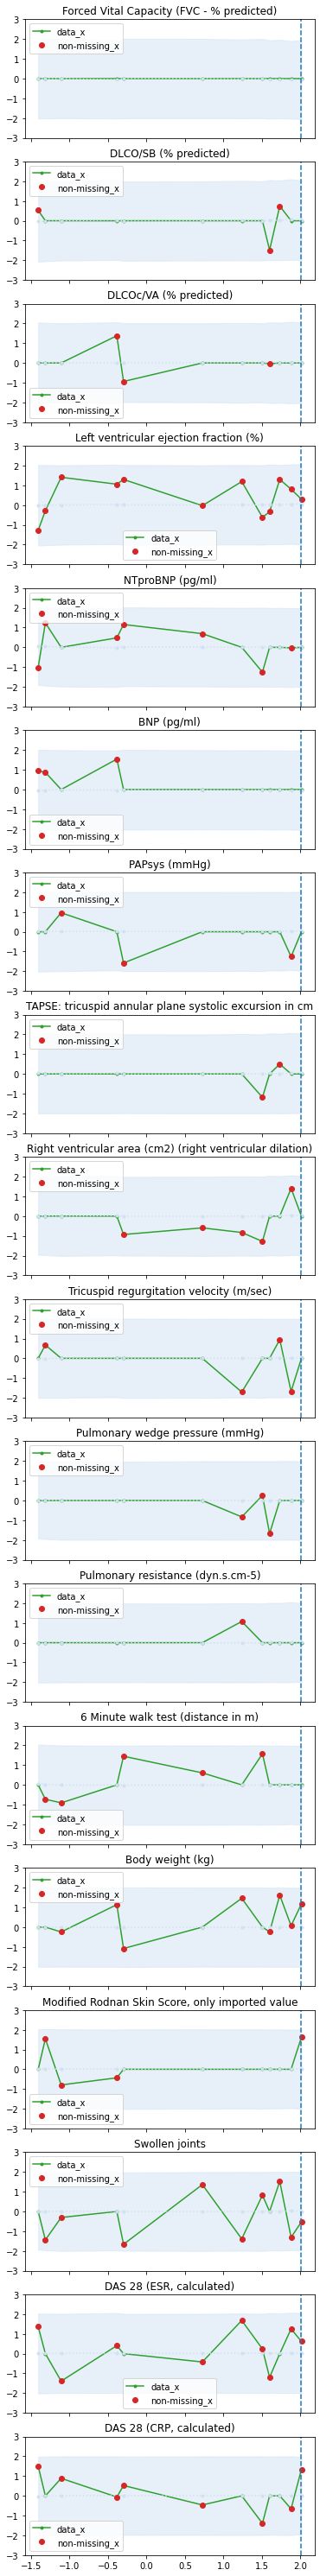

In [28]:
plot_x_overlaid(data_x, x_recon[0].reshape(1, len(times),data_x.shape[1]), torch.sqrt(torch.exp(x_recon_log_var[0])).reshape(1, len(times), data_x.shape[1]), time, inputs["missing_x"], [1], names_x, kinds_x1)

In [20]:
torch.split(samples[0].recon_x, splits * splits[0])[0].shape

torch.Size([12, 61])

In [8]:
def plot_x_overlaid(
    data_x,
    recon_x_mean,
    recon_x_std,
    time,
    missing_x,
    num_to_pred_flat,
    names_x,
    kinds_x1,
    figsize=(6, 3),
):
    recon_x_means = [elem.detach().numpy() for elem in recon_x_mean]
    recon_x_stds = [elem.detach().numpy() for elem in recon_x_std]
    # nP = data_x.shape[1]
    cont = [elem for elem in kinds_x1 if elem in ["continuous", "ordinal"]]
    cont_indices = [
        i for i, elem in enumerate(kinds_x1) if elem in ["continuous", "ordinal"]
    ]
    nP = len(cont)
    # create figure with subplots
    f, axs = plt.subplots(
        nP, 1, sharex=True, sharey=False, figsize=(1 * figsize[0], nP * figsize[1])
    )
    f.subplots_adjust(hspace=0.2)  # , wspace=0.2)
    colors = plt.cm.Blues(np.linspace(0.2, 1, len(recon_x_means)))
    for j, i in enumerate(cont_indices):
        if nP > 1:
            ax = axs[j]
        else:
            ax = axs
        ax.plot(time, data_x[:, i], ".-", color="C2", label="data_x")

        for index in range(len(recon_x_means)):
            ax.plot(time, recon_x_means[index][:, i], ".:", color=colors[index])
            ax.fill_between(
                time,
                recon_x_means[index][:, i] - 2 * recon_x_stds[index][:, i],
                recon_x_means[index][:, i] + 2 * recon_x_stds[index][:, i],
                alpha=0.5,
                color=colors[index],
            )

        non_miss = ~missing_x[:, i]
        ax.plot(
            time[non_miss],
            data_x[non_miss, i],
            "o",
            color="C3",
            label="non-missing_x",
        )

        if not names_x is None:
            ax.set_title(names_x[i])
        ax.axvline(time[-num_to_pred_flat[0]] - 0.01, ls="--")
        ax.set_ylim(-3, 3)
        ax.legend()

In [75]:
from pythae.models.beta_vae_gp.plots import plot_losses, plot_recon_losses

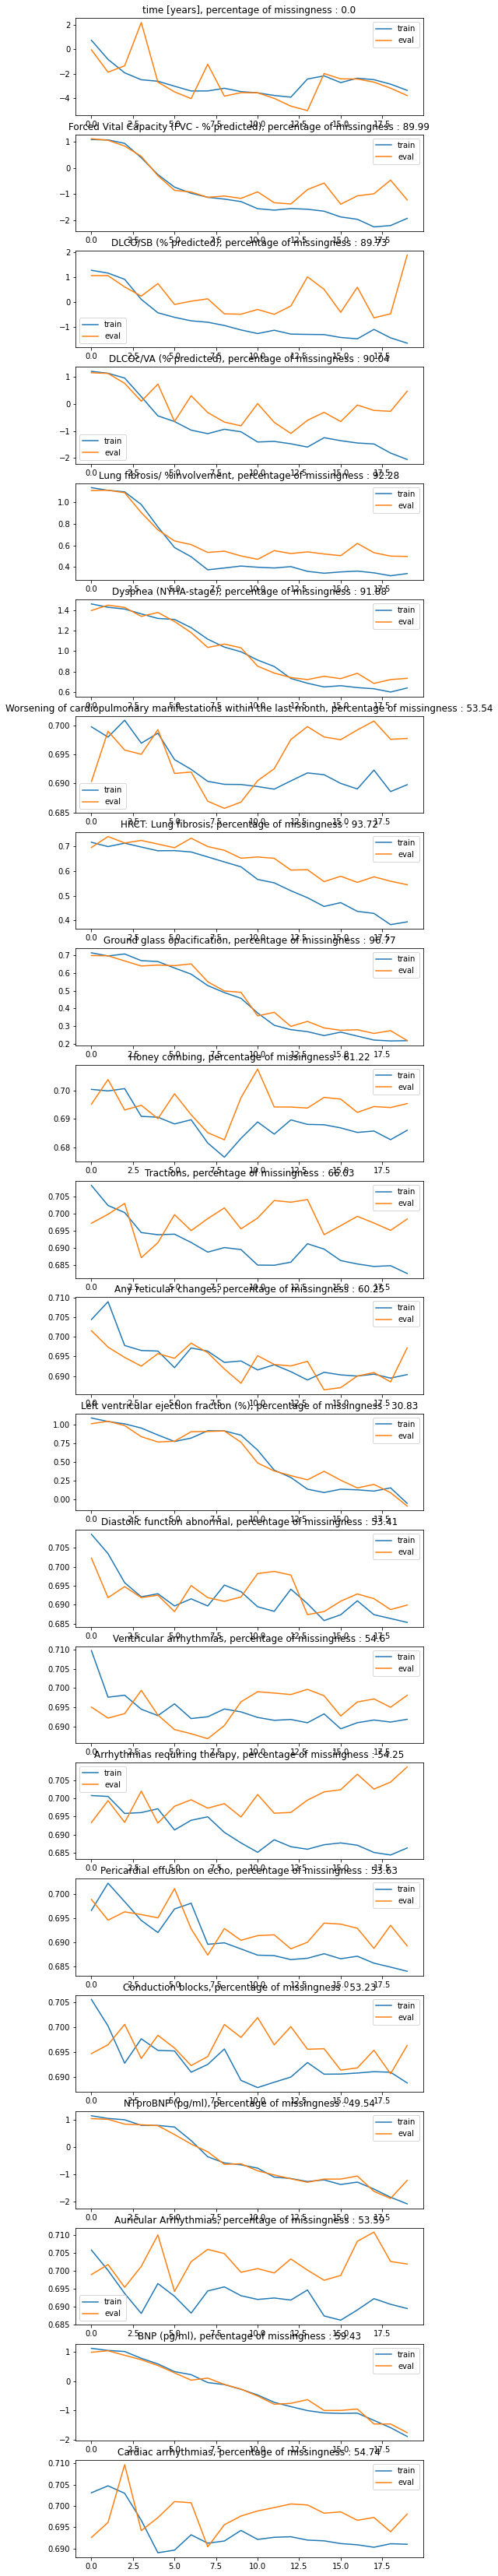

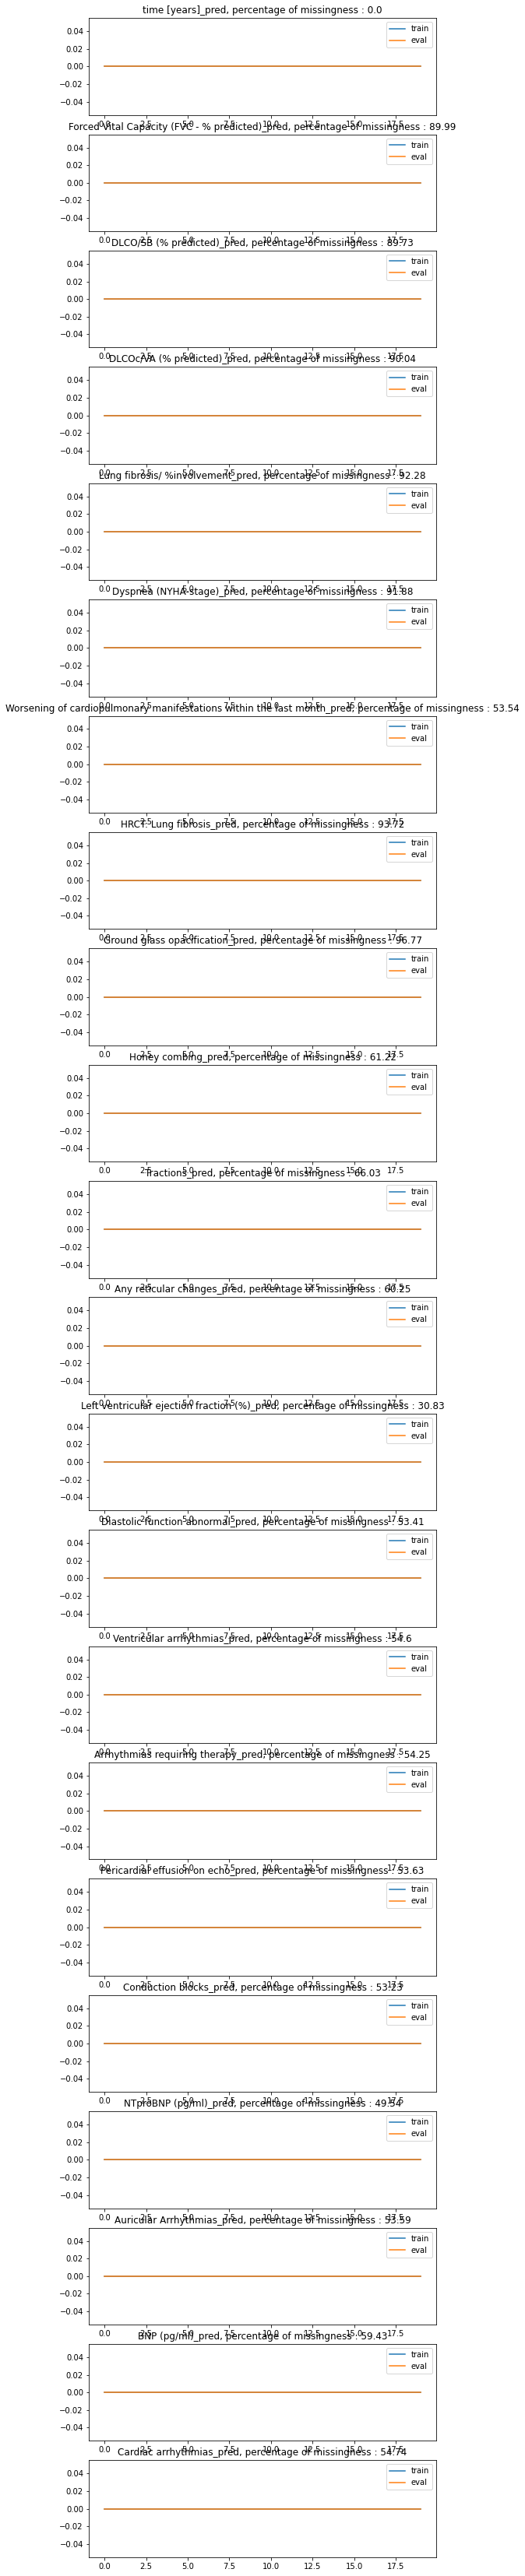

In [76]:
plot_recon_losses(pipeline, data_train)

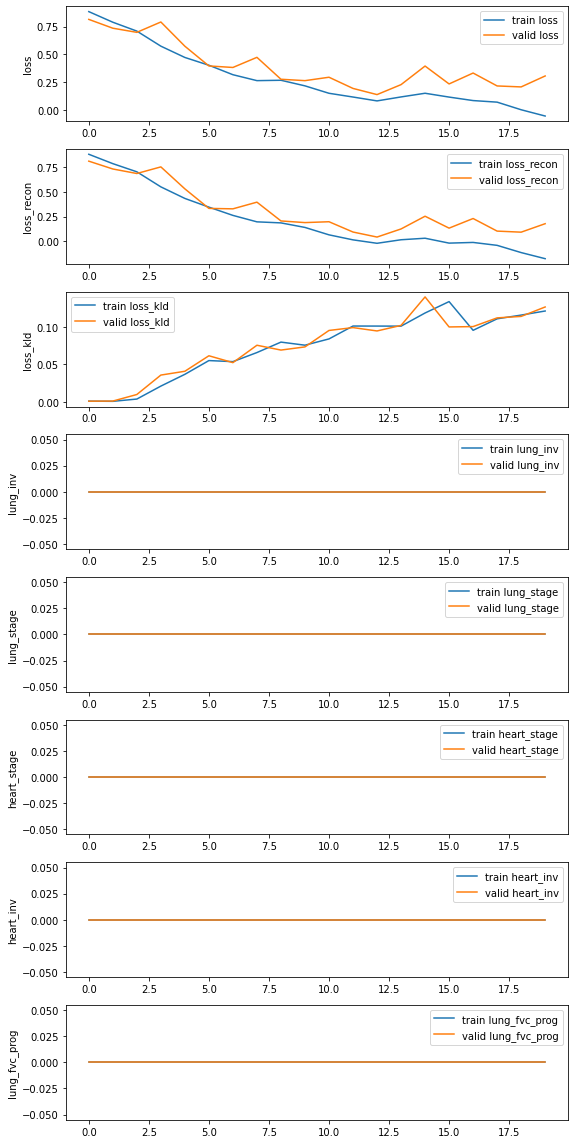

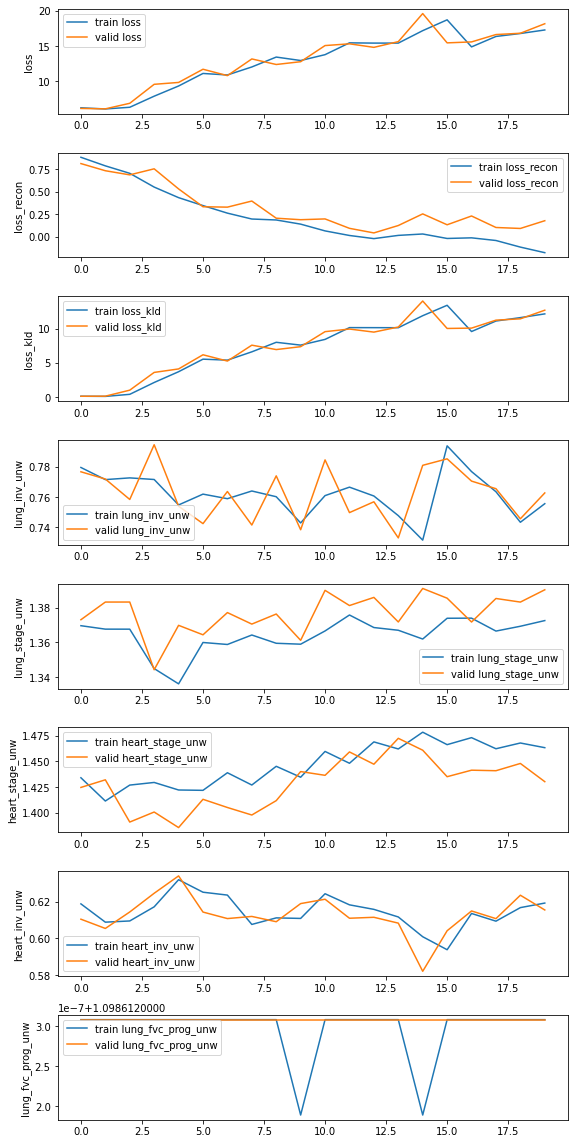

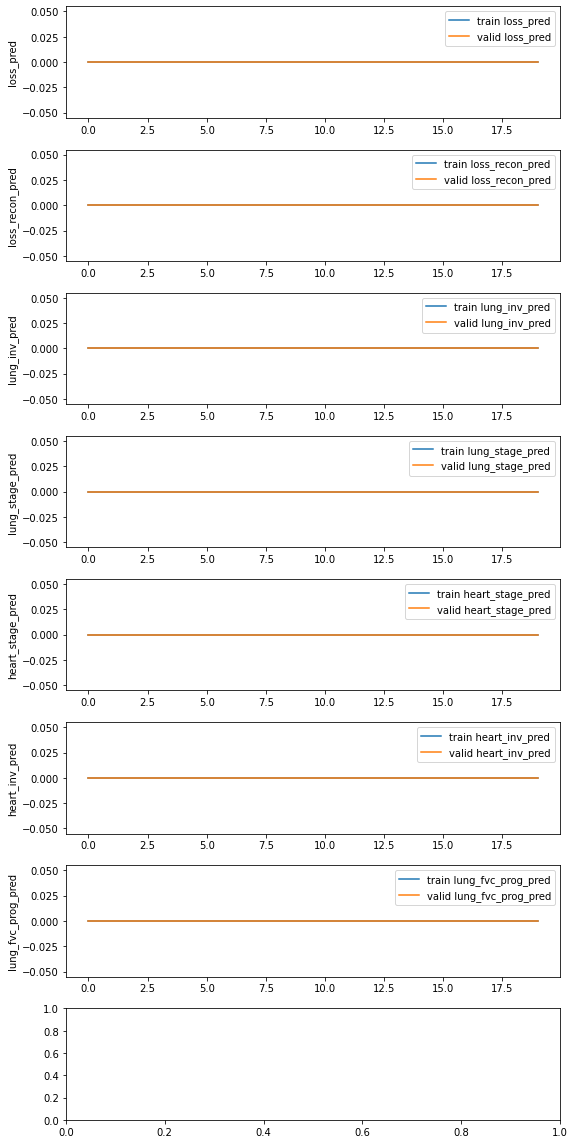

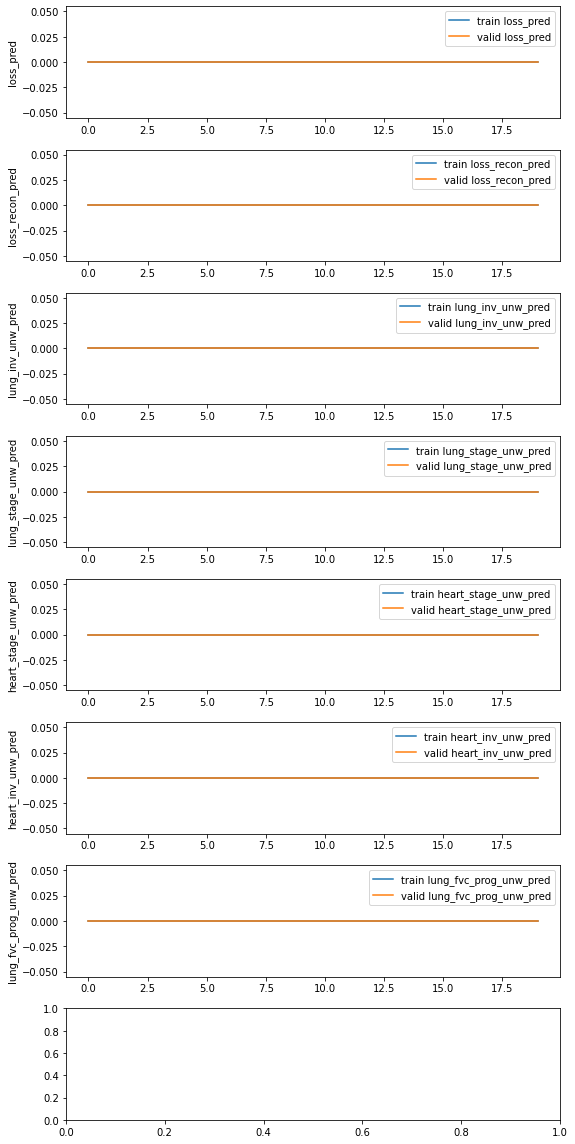

In [103]:
plot_losses(pipeline)

In [91]:
#model.model_config.num_for_rec = "last"

In [104]:
# test stuff
# model.model_config.num_for_rec = "last"
sample_batch_test = data_test.get_ith_sample_batch_with_customDataLoader(45, 1)
time = sample_batch_test.data_x[:,0]
out = model(sample_batch_test)
res_matrix, probs_matrix, res_list = body.decode_preds(out.recon_x, splits_x0, names_x0)
res_matrix_y, probs_matrix_y, res_list_y = body.decode_preds(out.y_out_rec, splits_y0, names_y0)
res_matrix_m, probs_matrix_m, res_list_m = body.decode_preds(out.recon_m, splits_x0, names_x0)

In [105]:
inputs = sample_batch_test
data_x = inputs["data_x"]
non_missing_x = 1 - inputs["missing_x"] * 1.0
splits = inputs["splits"]  # N_patients
times = inputs["data_x"][:, 0].reshape(-1, 1)  # N_patients x 1
non_missing_y = 1 - inputs["missing_y"] * 1.0  # N_patients x n_class
data_y = inputs["data_y"]  # N_patients x n_class


In [106]:
names_x = [vN for i,vN in enumerate(varNames) if xyt1[i]=='x']
kinds_x1 = [item  for i,spl in enumerate(splits_x0) for item in [kinds_x0[i]]*spl ]
num_samples = 12
samples = [model(sample_batch_test) for i in range(num_samples)]
# for each sample split into the different predictions
out_x_recon_splitted = [elem.recon_x.split(splits) for elem in samples]
# for each sample split into the different predictions
out_y_recon_splitted = [elem.y_out_rec.split(splits) for elem in samples]

In [107]:
x_recon = torch.stack([elem.recon_x for elem in samples])
x_recon_log_var = torch.stack([elem.recon_x_log_var for elem in samples])


In [108]:
tmp = torch.normal(x_recon, torch.exp(x_recon_log_var))
x_recon_means = torch.mean(tmp, dim=0)
x_recon_std = torch.std(tmp, dim=0)

In [109]:
from pythae.models.beta_vae_gp.plots import plot_x_overlaid

In [110]:
data_x.shape

torch.Size([10, 27])

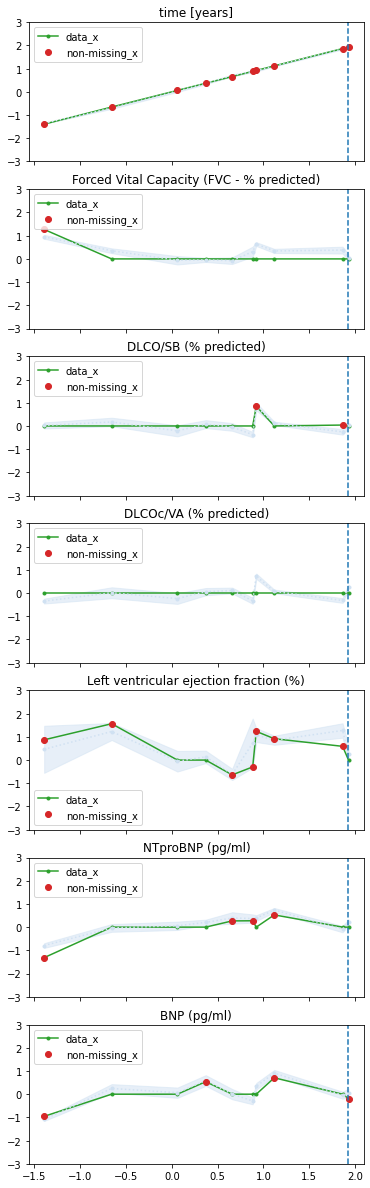

In [111]:
plot_x_overlaid(data_x, x_recon_means.reshape(1, len(times),data_x.shape[1]), x_recon_std.reshape(1, len(times), data_x.shape[1]), time, inputs["missing_x"], [1], names_x, kinds_x1)

In [43]:
sample_batch_test.data_x.shape

torch.Size([10, 62])

In [35]:
samples[0].recon_x_log_var.shape

torch.Size([10, 62])

In [20]:
i = 0
recon_x_all = []
for i in range(len(splits)):
    x_recon = [elem[i] for elem in out_x_recon_splitted]
    recon_x_all.append(x_recon) 

In [21]:
recon_x_all

[[tensor([[-1.2378e+00,  3.2746e-01,  5.0217e-01, -1.0439e-01,  2.4999e-01,
            2.3687e-01, -3.4447e-02,  1.8220e-02,  5.7035e-01,  9.3482e-01,
            3.4757e-01,  8.1735e-02, -5.6085e-01, -1.2714e-01, -3.4890e-01,
            2.1950e-02, -1.5178e-02, -2.4079e-01, -6.3473e-02,  1.0916e-01,
           -1.3124e-01, -1.3411e-01, -1.6449e-01, -4.7260e-02, -1.5179e-01,
            3.5714e-01,  2.8136e-01,  1.6106e-01, -2.3085e-01, -7.7306e-02,
            3.9847e-01, -1.5625e-01,  3.0343e-02,  1.8509e-01,  1.0359e-01,
           -1.8185e-01,  1.0239e-01, -3.5252e-01, -5.5043e-02, -2.5442e-01,
            3.8943e-01,  3.7156e-01,  4.7911e-01,  2.0452e-01, -4.0193e-01,
           -2.0109e-01, -3.2721e-01, -8.0898e-01, -5.2272e-01, -3.6837e-01,
           -2.2583e-02,  1.4951e-01,  3.0206e-01,  5.9758e-01,  3.9229e-02,
           -1.5799e-01, -4.3193e-02, -2.6922e-01, -2.1820e-01,  1.4601e-01,
           -6.0221e-03, -1.6390e-01],
          [-2.1716e-01,  2.3623e-02,  8.2895e-02, 

In [32]:
inputs = sample_batch_test
data_x = inputs["data_x"]
non_missing_x = 1 - inputs["missing_x"] * 1.0
splits = inputs["splits"]  # N_patients
times = inputs["data_t"][:, 0].reshape(-1, 1)  # N_patients x 1
non_missing_y = 1 - inputs["missing_y"] * 1.0  # N_patients x n_class
data_y = inputs["data_y"]  # N_patients x n_class


In [168]:
(
    data_x_recon,
    data_y_recon,
    non_missing_x_recon,
    non_missing_y_recon,
    data_x_pred,
    data_y_pred,
    non_missing_x_pred,
    non_missing_y_pred,
    times_recon, 
    times_pred,
    times_pred_grouped,
    splits_flattened,
    num_for_rec,
    num_for_rec_flat,
    num_to_pred,
    num_to_pred_flat,
    num_to_rec_num_to_pred,
) = model.get_splits_for_prediction(
    data_x, data_y, non_missing_x, non_missing_y, splits, times
)

In [41]:
data_x_recon.split(num_for_rec_flat)

(tensor([[-1.3925,  1.2699,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  0.8730,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000, -1.3142,
           1.0000, -0.9543,  1.0000,  1.2133,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
           1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000, -0.2542,  1.0000,  0.0000,  1.0000,  0.0000],
         [-0.6560,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  1.5666,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.00

In [3]:
model.model_config.num_for_rec = "last"

In [18]:
sample_batch_test2 = data_test.get_ith_sample_batch_with_customDataLoader(2,50)
inputs = sample_batch_test2
data_x = inputs["data_x"]
non_missing_x = 1 - inputs["missing_x"] * 1.0
splits = inputs["splits"]  # N_patients
times = inputs["data_x"][:, 0].reshape(-1, 1)  # N_patients x 1
non_missing_y = 1 - inputs["missing_y"] * 1.0  # N_patients x n_class
data_y = inputs["data_y"]  # N_patients x n_class
(
    data_x_recon,
    data_y_recon,
    non_missing_x_recon,
    non_missing_y_recon,
    data_x_pred,
    data_y_pred,
    non_missing_x_pred,
    non_missing_y_pred,
    times_recon, 
    times_pred,
    times_pred_grouped,
    splits_flattened,
    num_for_rec,
    num_for_rec_flat,
    num_to_pred,
    num_to_pred_flat,
    num_to_rec_num_to_pred,
) = model.get_splits_for_prediction(
    data_x, data_y, non_missing_x, non_missing_y, splits, times)

In [5]:
out2 = model(inputs)

In [6]:
res_matrix2, probs_matrix2, res_list2 = body.decode_preds(out2.recon_x, splits_x0, names_x0)
res_matrix_y2, probs_matrix_y2, res_list_y2 = body.decode_preds(out2.y_out_rec, splits_y0, names_y0)
res_matrix2_pred, probs_matrix2_pred, res_list2_pred = body.decode_preds(out2.recon_x_pred, splits_x0, names_x0)
res_matrix_y2_pred, probs_matrix_y2_pred, res_list_y2_pred = body.decode_preds(out2.y_out_pred, splits_y0, names_y0)

In [7]:
true_labels_y2, _ = body.decode(data_y_recon, splits_y0, names_y0)
true_labels_y2_pred, _ = body.decode(data_y_pred, splits_y0, names_y0)

In [8]:
list_of_arrays_pred = np.split(non_missing_y_pred, np.cumsum(splits_y0[:-1]), axis=1)
list_of_arrays_recon = np.split(non_missing_y_recon, np.cumsum(splits_y0[:-1]), axis=1)

In [9]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
predicted_cats = torch.empty_like(res_matrix_y2)
for index, var in enumerate(names_y0): 
    predicted_cats[:,index] = body.get_var_by_name(var).get_categories(res_matrix_y2[:,index])
for i, elem in enumerate(list_of_arrays_recon):
    indices = elem.all(axis=1)
    print(confusion_matrix(true_labels_y2[indices,i], predicted_cats[indices, i]))
    print(classification_report(true_labels_y2[indices,i], predicted_cats[indices, i]))

IndexError: index 1 is out of bounds for axis 0 with size 1

In [17]:
# missing_x_recon = torch.cat([elem[:-1, :] for elem in inputs["missing_x"].split(splits)])
# data_x_recon = torch.cat([elem[:-1, :] for elem in inputs["data_x"].split(splits)])

In [19]:
true_labels_x2, _ = body.decode(data_x_recon, splits_x0, names_x0)
true_labels_x2_pred, _ = body.decode(out2.data_x_pred, splits_x0, names_x0)

In [20]:
df_results = pd.DataFrame(np.nan, columns = names_x0, index = ['acc_recon', 'acc_pred', 'f1_recon', 'f1_pred', 'mae_recon', 'mae_pred'])

In [21]:
import sklearn

time [years]
2.0934615498456686
Forced Vital Capacity (FVC - % predicted)
27.782029214317493
DLCO/SB (% predicted)
30.50165906811575
DLCOc/VA (% predicted)
26.165213684580635
Lung fibrosis/ %involvement
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         5
         0.0       0.38      0.31      0.34        29
         1.0       0.40      0.30      0.34        20
         2.0       0.00      0.00      0.00         0

    accuracy                           0.28        54
   macro avg       0.19      0.15      0.17        54
weighted avg       0.35      0.28      0.31        54

Dyspnea (NYHA-stage)
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.50      0.18      0.26        17
         2.0       0.00      0.00      0.00        10
         3.0       0.33      0.12      0.17        17
         4.0       0.00      0.00      0.00        16

    accuracy   

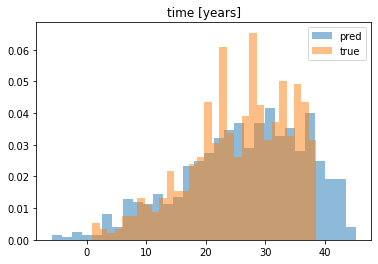

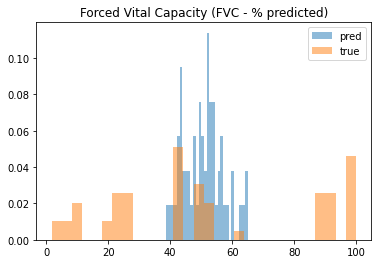

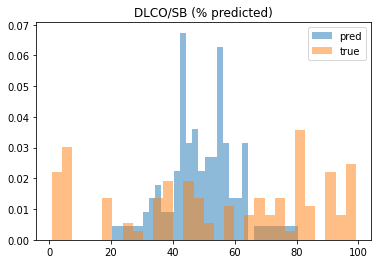

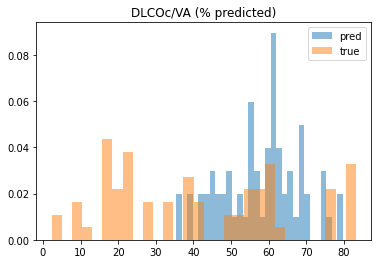

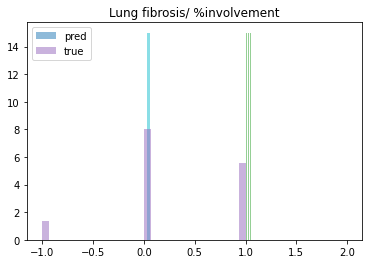

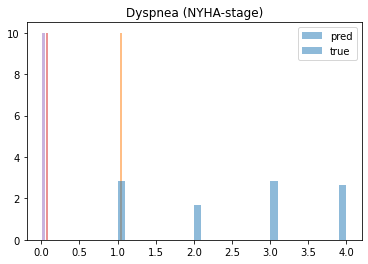

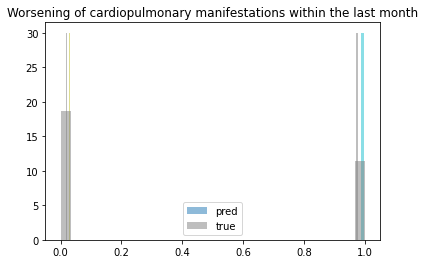

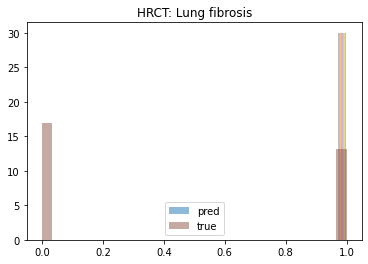

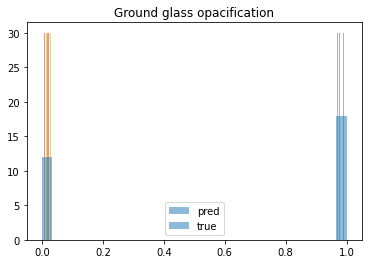

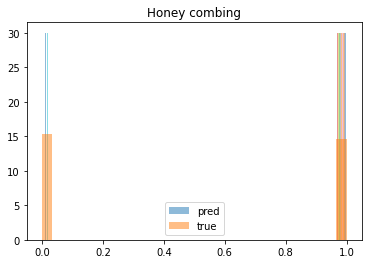

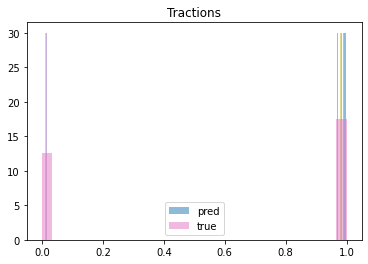

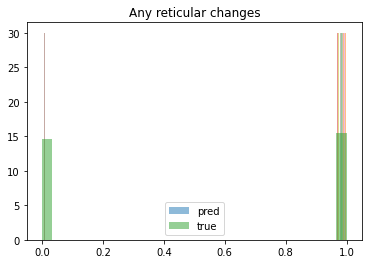

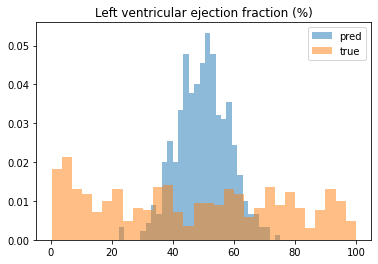

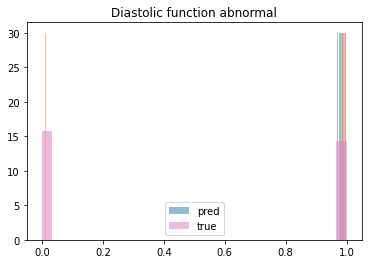

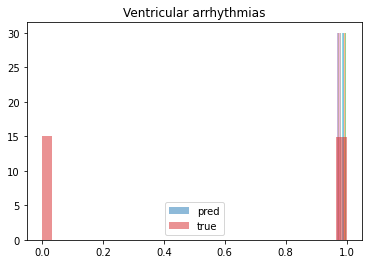

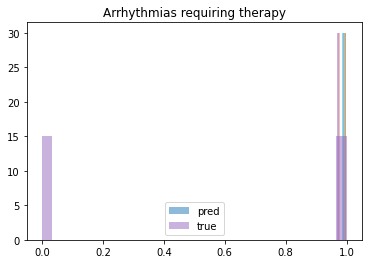

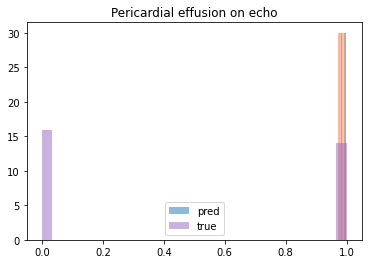

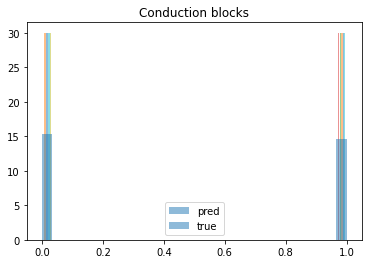

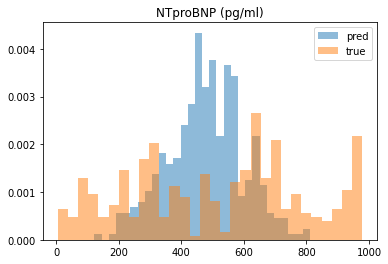

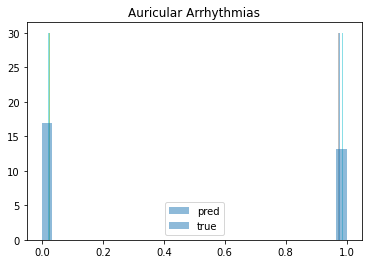

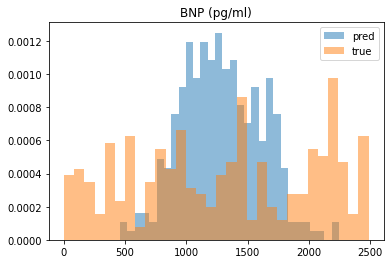

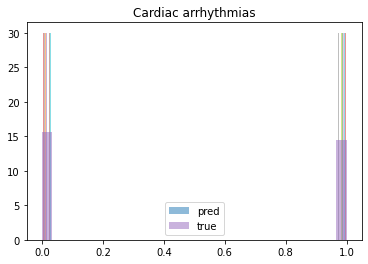

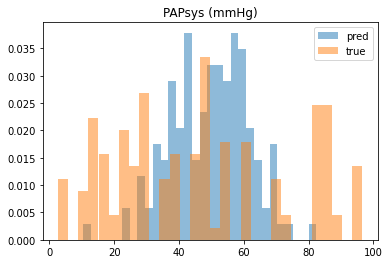

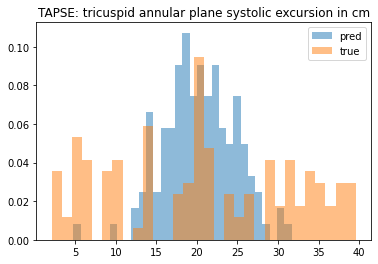

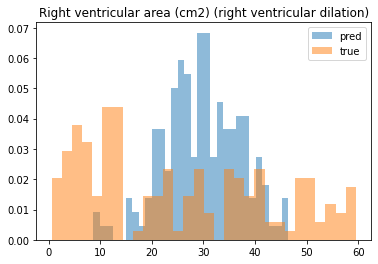

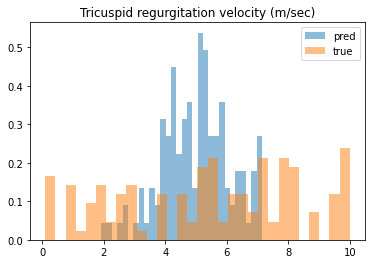

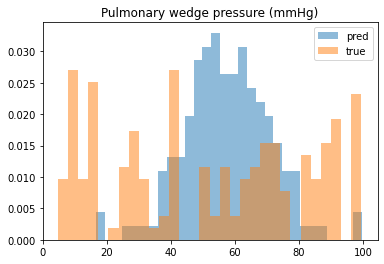

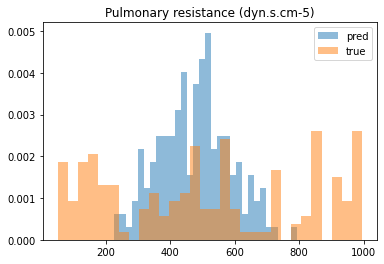

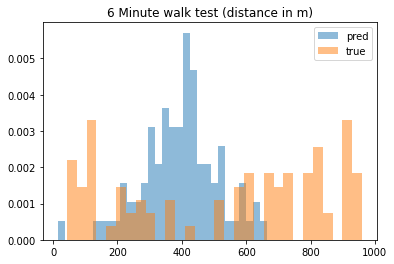

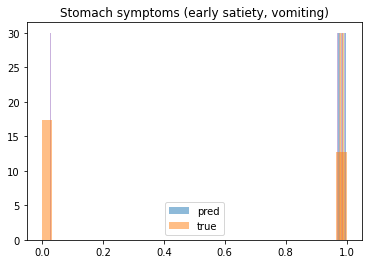

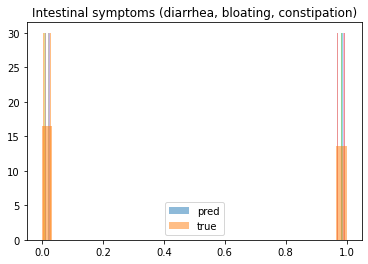

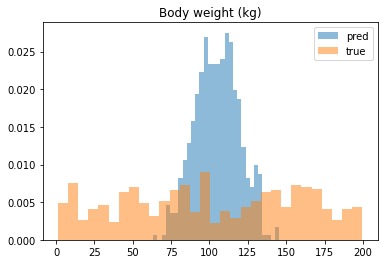

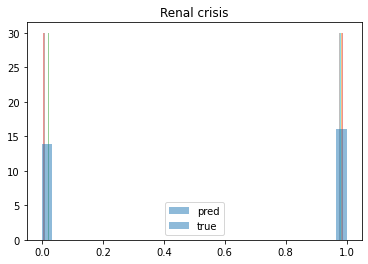

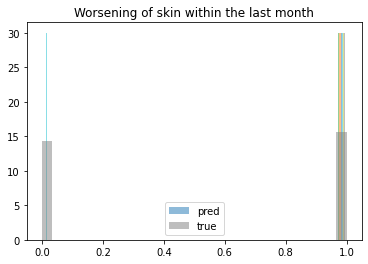

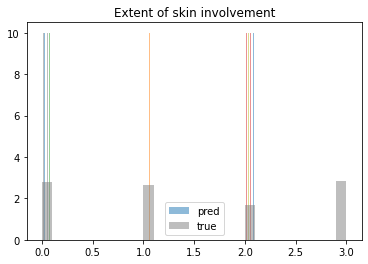

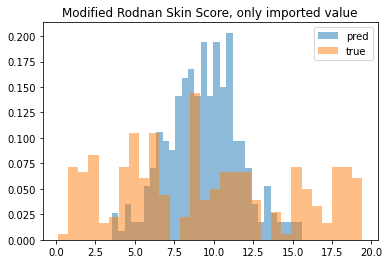

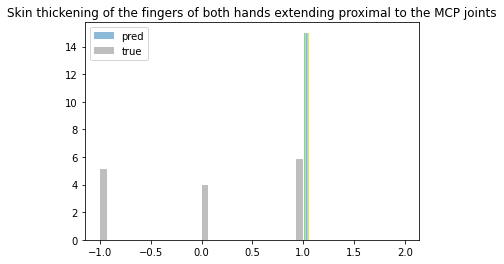

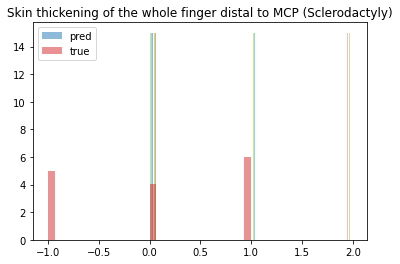

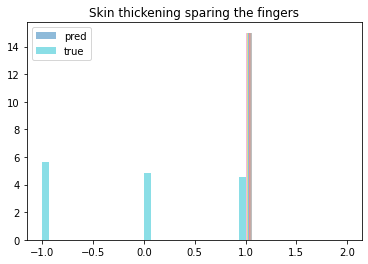

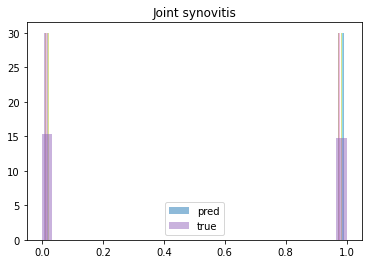

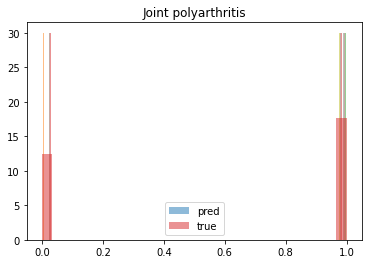

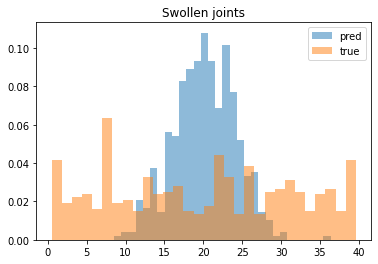

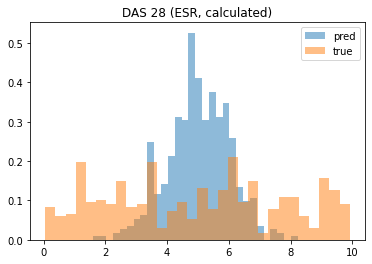

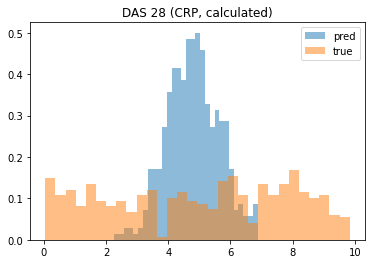

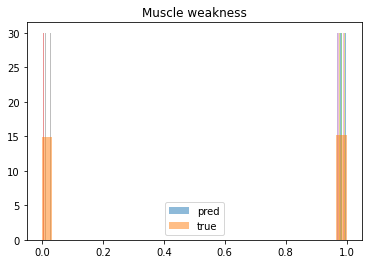

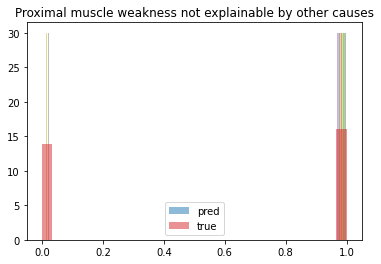

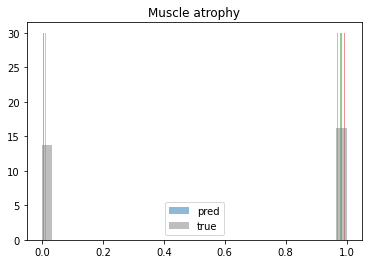

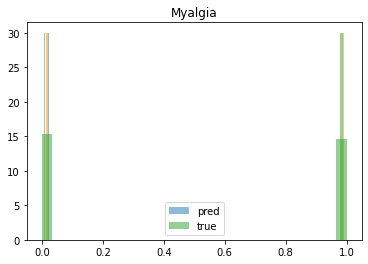

In [22]:
list_of_arrays_recon_pred = np.split(out2.non_missing_x_pred, np.cumsum(splits_x0[:-1]), axis=1)
s = np.concatenate([[0], np.cumsum(splits_x0)])
for i, elem in enumerate(list_of_arrays_recon_pred):
    name = names_x0[i]
    indices = elem.all(axis=1)
    if indices.any():
        print(name)
        var = body.get_var_by_name(name)
        if var.kind == 'continuous':
            preds = var.decode(out2.recon_x_pred[indices, s[i]:s[i+1]].detach()).flatten()
            mae = (abs(preds- true_labels_x2_pred[indices,i].detach().numpy())).mean().item()
            print(mae)
            df_results.loc['mae_pred', name] = mae
            plt.figure()
            plt.hist(preds, label = 'pred', alpha = 0.5, density = True, bins = 30)
            plt.hist(true_labels_x2_pred[indices,i].detach().numpy(), label = 'true', alpha = 0.5, bins = 30, density = True)
            plt.title(name)
            plt.legend()
        else:
            preds = var.decode_(out2.recon_x_pred[indices, s[i]:s[i+1]].detach())[0].flatten()
            acc = sklearn.metrics.accuracy_score(true_labels_x2_pred[indices,i], preds)
            f1_macro = sklearn.metrics.f1_score(true_labels_x2_pred[indices,i], preds, average = 'macro')
            df_results.loc['f1_pred', name] = f1_macro
            df_results.loc['acc_pred', name] = acc
            print(classification_report(true_labels_x2_pred[indices,i], preds))
            plt.figure()
            plt.hist(preds, label = 'pred', alpha = 0.5, density = True, bins = 30)
            plt.hist(true_labels_x2_pred[indices,i].detach().numpy(), label = 'true', alpha = 0.5, bins = 30, density = True)
            plt.title(name)
            plt.legend()

In [13]:
recon_x_all = torch.cat([out.recon_x, out.recon_x_pred])
recon_m_all = torch.cat([out.recon_m, out.recon_m_pred])
y_out_all = torch.cat([out.y_out_rec, out.y_out_pred])
y_out_m_all = torch.cat([out.y_out_m_rec, out.y_out_m_pred])

In [14]:
res_matrix_all, probs_matrix_all, res_list_all = body.decode_preds(recon_x_all, splits_x0, names_x0)
res_matrix_y_all, probs_matrix_y_all, res_list_y_all = body.decode_preds(y_out_all, splits_y0, names_y0)
res_matrix_m_all, probs_matrix_m_all, res_list_m_all = body.decode_preds(recon_m_all, splits_x0, names_x0)

In [15]:

res_matrix_pred, probs_matrix_pred, res_list_pred = body.decode_preds(out.recon_x_pred, splits_x0, names_x0)
res_matrix_y_pred, probs_matrix_y_pred, res_list_y_pred = body.decode_preds(out.y_out_pred, splits_y0, names_y0)
res_matrix_m_pred, probs_matrix_m_pred, res_list_m_pred = body.decode_preds(out.recon_m_pred, splits_x0, names_x0)

In [16]:
mu_all = torch.cat([out.mu, out.mu_pred])
log_var_all = torch.cat([out.log_var, out.log_var_pred])

ValueError: x and y must have same first dimension, but have shapes torch.Size([10]) and (80,)

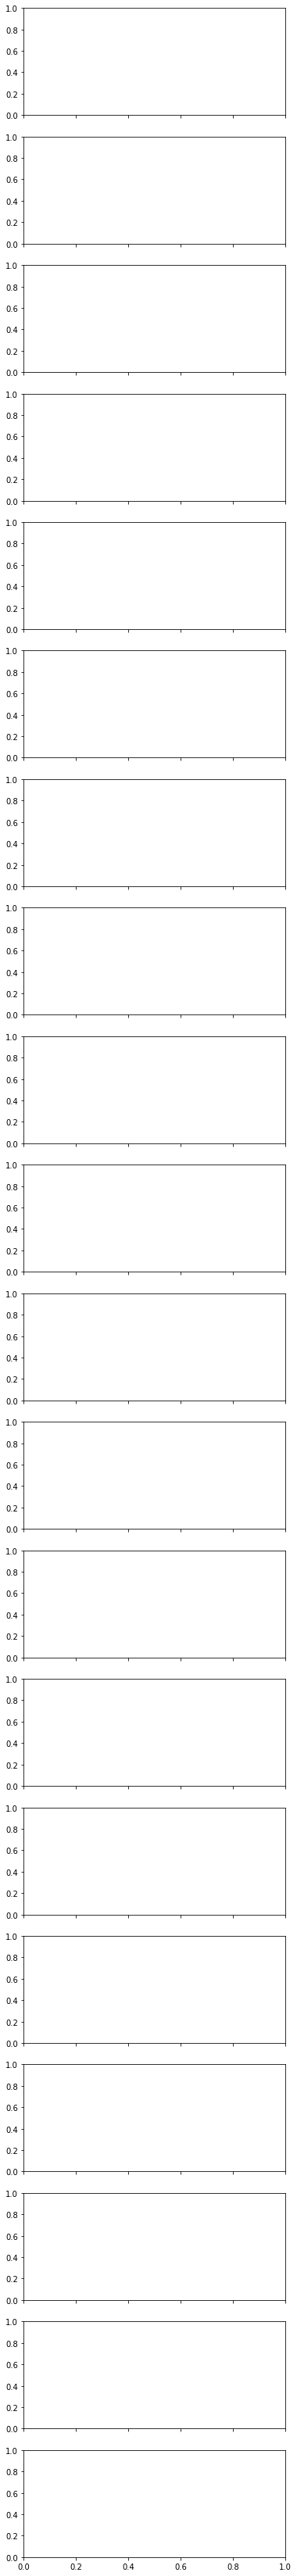

In [17]:
model.plot_z(out.z, mu_all, log_var_all, time)

In [72]:
names_x = [vN for i,vN in enumerate(varNames) if xyt1[i]=='x']
kinds_x1 = [item  for i,spl in enumerate(splits_x0) for item in [kinds_x0[i]]*spl  ]


In [53]:
data_x_recon_splitted = data_x_recon.split(num_for_rec_flat)
out_x_recon_splitted = out.recon_x.split(num_for_rec_flat)

In [54]:
data_x_pred_splitted = data_x_pred.split(num_to_pred_flat)
out_x_pred_splitted = out.recon_x_pred.split(num_to_pred_flat)

In [56]:
out_x_recon_splitted[0].shape

torch.Size([5, 62])

In [151]:
num_samples = 12
samples = [model(sample_batch_test) for i in range(num_samples)]

In [152]:
# for each sample split into the different predictions
out_x_pred_splitted = [elem.recon_x_pred.split(num_to_pred_flat) for elem in samples]
out_x_recon_splitted = [elem.recon_x.split(num_for_rec_flat) for elem in samples]

In [153]:
out_x_pred_mean_splitted = out_x_pred_mean.split(num_to_pred_flat)
out_x_pred_std_splitted = out_x_pred_std.split(num_to_pred_flat)
out_x_recon_mean_splitted = out_x_recon_mean.split(num_for_rec_flat)
out_x_recon_std_splitted = out_x_recon_std.split(num_for_rec_flat)

In [162]:
# predict last i samples
i = 0
recon_x_all = []
for i in range(len(num_for_rec_flat)):
    x_pred = [elem[i] for elem in out_x_pred_splitted]
    x_recon = [elem[i] for elem in out_x_recon_splitted]
    recon_x_all.append([torch.cat([x_recon[j], x_pred[j]]) for j in range(len(x_pred))]) 

In [163]:
probs_matrix_all = []
for i in range(len(num_for_rec_flat)):

    probs_matrix_all.append([body.decode_preds(elem, splits_x0, names_x0)[1] for elem in recon_x_all[i]])

In [164]:
recon_x_all_means = [torch.stack(recon_x_all[i]).mean(axis = 0) for i in range(len(num_for_rec_flat))]
recon_x_all_stds = [torch.stack(recon_x_all[i]).std(axis = 0) for i in range(len(num_for_rec_flat))]
probs_matrix_all_means = [torch.stack(probs_matrix_all[i]).mean(axis = 0) for i in range(len(num_for_rec_flat))]
probs_matrix_all_stds = [torch.stack(probs_matrix_all[i]).std(axis = 0) for i in range(len(num_for_rec_flat))]

In [94]:
recon_x_all_mean = torch.stack(recon_x_all).mean(axis = 0)
recon_x_all_std = torch.stack(recon_x_all).std(axis = 0)
probs_matrix_all_mean = torch.stack(probs_matrix_all).mean(axis = 0)
probs_matrix_all_std = torch.stack(probs_matrix_all).std(axis = 0)

# recon_m_all = [torch.cat([sample.recon_m, sample.recon_m_pred]) for sample in samples]
# y_out_all = [torch.cat([sample.y_out_rec, sample.y_out_pred]) for sample in samples]
# y_out_m_all = [torch.cat([sample.y_out_m_rec, sample.y_out_m_pred]) for sample in samples]

In [95]:
data_x.shape

torch.Size([10, 62])

In [96]:
def plot_x(
    data_x,
    recon_x_mean,
    recon_x_std,
    time,
    missing_x,
    names_x=None,
    probs_matrix=None,
    probs_matrix_std = None,
    kinds_x1=None,
    figsize=(6, 3),
):
    recon_x = recon_x_mean.detach().numpy()
    recon_std = recon_x_std.detach().numpy()
    if not probs_matrix is None:
        probs_matrix = probs_matrix.detach().numpy()
    if not probs_matrix_std is None:
        probs_matrix_std = probs_matrix_std.detach().numpy()
    nP = data_x.shape[1]

    # create figure with subplots
    f, axs = plt.subplots(
        nP, 1, sharex=True, sharey=False, figsize=(1 * figsize[0], nP * figsize[1])
    )
    f.subplots_adjust(hspace=0.2)  # , wspace=0.2)

    for i in range(nP):
        if nP > 1:
            ax = axs[i]
        else:
            ax = axs
        ax.plot(time, data_x[:, i], ".-", color="C2", label="data_x")

        if kinds_x1 is None:
            ax.plot(time, recon_x[:, i], ".:", color="C0", label="recon_x")

            if not probs_matrix is None:
                ax.plot(time, probs_matrix[:, i], ".:", color="C1", label="probs")
        else:
            if kinds_x1[i] in ["continuous", "ordinal"]:
                ax.plot(time, recon_x[:, i], ".:", color="C0", label="recon_x")
                ax.fill_between(time, recon_x[:, i] - recon_std[:, i], recon_x[:, i] + recon_std[:, i], alpha=0.5)
            else:
                if not probs_matrix is None:
                    ax.plot(
                        time, probs_matrix[:, i], ".:", color="C1", label="probs"
                    )
                if not probs_matrix_std is None:
                    ax.fill_between(time, probs_matrix[:, i] - probs_matrix_std[:, i], probs_matrix[:, i] + probs_matrix_std[:, i], alpha=0.5)

        non_miss = ~missing_x[:, i]
        ax.plot(
            time[non_miss],
            data_x[non_miss, i],
            "o",
            color="C3",
            label="non-missing_x",
        )

        if not names_x is None:
            ax.set_title(names_x[i])

        ax.set_ylim(-3, 3)
        ax.legend()

In [165]:
def plot_x_overlaid(
    data_x,
    recon_x_mean,
    recon_x_std,
    time,
    missing_x,
    names_x=None,
    probs_matrix=None,
    probs_matrix_std = None,
    kinds_x1=None,
    figsize=(6, 3),
):
    recon_x_means = [elem.detach().numpy() for elem in recon_x_mean]
    recon_x_stds = [elem.detach().numpy() for elem in recon_x_std]
    if not probs_matrix is None:
        probs_matrix = [elem.detach().numpy() for elem in probs_matrix]
    if not probs_matrix_std is None:
        probs_matrix_std = [elem.detach().numpy() for elem in probs_matrix_std]
    nP = data_x.shape[1]

    # create figure with subplots
    f, axs = plt.subplots(
        nP, 1, sharex=True, sharey=False, figsize=(1 * figsize[0], nP * figsize[1])
    )
    f.subplots_adjust(hspace=0.2)  # , wspace=0.2)

    for i in range(nP):
        if nP > 1:
            ax = axs[i]
        else:
            ax = axs
        ax.plot(time, data_x[:, i], ".-", color="C2", label="data_x")

        for index in range(len(recon_x_means)):
            if kinds_x1 is None:
                ax.plot(time, recon_x_means[index][:, i], ".:", color="C0", label="recon_x")

                if not probs_matrix is None:
                    ax.plot(time, probs_matrix[index][:, i], ".:", color="C1", label="probs")
            else:
                if kinds_x1[i] in ["continuous", "ordinal"]:
                    ax.plot(time, recon_x_means[index][:, i], ".:", color="C0", label="recon_x")
                    ax.fill_between(time, recon_x_means[index][:, i] - recon_x_stds[index][:, i], recon_x_means[index][:, i] + recon_x_stds[index][:, i], alpha=0.5)
                else:
                    if not probs_matrix is None:
                        ax.plot(
                            time, probs_matrix[index][:, i], ".:", color="C1", label="probs"
                        )
                    if not probs_matrix_std is None:
                        ax.fill_between(time, probs_matrix[index][:, i] - probs_matrix_std[index][:, i], probs_matrix[index][:, i] + probs_matrix_std[index][:, i], alpha=0.5)

        non_miss = ~missing_x[:, i]
        ax.plot(
            time[non_miss],
            data_x[non_miss, i],
            "o",
            color="C3",
            label="non-missing_x",
        )

        if not names_x is None:
            ax.set_title(names_x[i])

        ax.set_ylim(-3, 3)
        ax.legend()

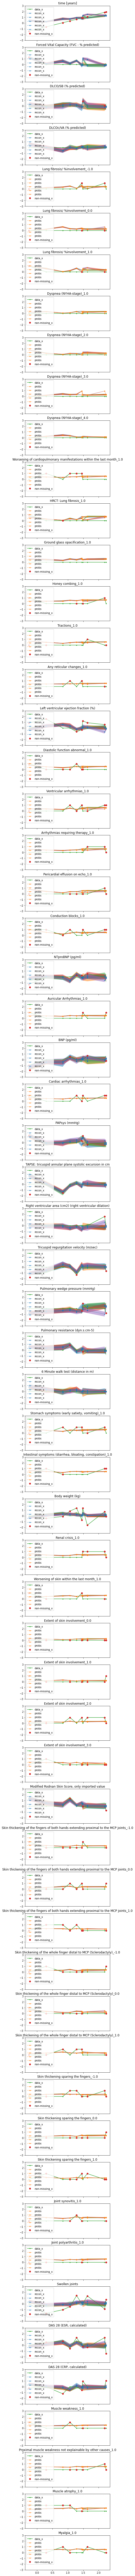

In [166]:
plot_x_overlaid(sample_batch_test.data_x, recon_x_all_means, recon_x_all_stds, time, 
                   sample_batch_test.missing_x, names_x, probs_matrix_all_means, probs_matrix_all_stds, kinds_x1 = kinds_x1)

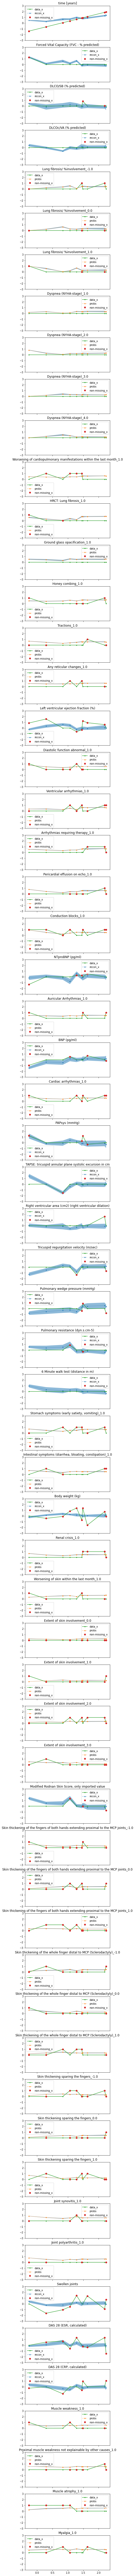

In [97]:
plot_x(sample_batch_test.data_x, recon_x_all_mean, recon_x_all_std, time, 
                   sample_batch_test.missing_x, names_x, probs_matrix_all_mean, probs_matrix_all_std, kinds_x1 = kinds_x1)

In [15]:
missing_x_pred = ~(out.non_missing_x_pred>0)

In [16]:
missing_x_pred.shape

torch.Size([1, 61])

In [35]:
model.model_config.num_for_rec = "last"

In [36]:
sample_batch_test2 = data_test.get_ith_sample_batch_with_customDataLoader(2,50)
batch_test = data_test.reshape_for_prediction(sample_batch_test2, "last")
out2 = model(batch_test)
res_matrix2, probs_matrix2, res_list2 = body.decode_preds(out2.recon_x, splits_x0, names_x0)
res_matrix_y2, probs_matrix_y2, res_list_y2 = body.decode_preds(out2.y_out_rec, splits_y0, names_y0)
res_matrix2_pred, probs_matrix2_pred, res_list2_pred = body.decode_preds(out2.recon_x_pred, splits_x0, names_x0)
res_matrix_y2_pred, probs_matrix_y2_pred, res_list_y2_pred = body.decode_preds(out2.y_out_pred, splits_y0, names_y0)

In [9]:
sample_batch_test2 = data_test.get_ith_sample_batch_with_customDataLoader(2,50)
batch_test = data_test.reshape_for_prediction(sample_batch_test2, "all")
out2 = model(batch_test)

In [ ]:
    def reshape_input_for_lstm(self, data_x, splits):
        data_x_splitted = torch.split(data_x, splits, dim=0)
        data_x_padded = torch.nn.utils.rnn.pad_sequence(
            data_x_splitted, batch_first=True
        )
        data_x_padded = torch.nn.utils.rnn.pack_padded_sequence(
            data_x_padded, batch_first=True, lengths=splits, enforce_sorted=False
        )
        return data_x_padded

In [43]:

true_labels_y2, _ = body.decode(batch_test.data_y_recon, splits_y0, names_y0)
true_labels_y2_pred, _ = body.decode(out2.data_y_pred, splits_y0, names_y0)

In [44]:
true_labels_y2

tensor([[0., nan, nan, 1.],
        [0., nan, nan, 1.],
        [0., nan, nan, nan],
        ...,
        [0., nan, nan, 1.],
        [0., nan, nan, 1.],
        [0., nan, nan, 1.]])

In [45]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
predicted_cats = torch.empty_like(res_matrix_y2[:,:-1])
for index, var in enumerate(names_y0[:-1]): 
    predicted_cats[:,index] = body.get_var_by_name(var).get_categories(res_matrix_y2[:,index])

In [47]:
non_missing_y_recon = (1 - batch_test.missing_y_recon * 1)
list_of_arrays_recon = np.split(non_missing_y_recon, np.cumsum(splits_y0[:-1]), axis=1)

for i, elem in enumerate(list_of_arrays_recon[:-1]):
    indices = elem.all(axis=1)
    print(confusion_matrix(true_labels_y2[indices,i], predicted_cats[indices, i]))
    print(classification_report(true_labels_y2[indices,i], predicted_cats[indices, i]))

[[37]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        37

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

[[14  0  0  0]
 [31  0  0  0]
 [22  0  0  0]
 [21  0  0  0]]
              precision    recall  f1-score   support

         1.0       0.16      1.00      0.27        14
         2.0       0.00      0.00      0.00        31
         3.0       0.00      0.00      0.00        22
         4.0       0.00      0.00      0.00        21

    accuracy                           0.16        88
   macro avg       0.04      0.25      0.07        88
weighted avg       0.03      0.16      0.04        88

[[1]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1


In [48]:
# 0.74, 0.49, 0, 0.5
predicted_cats_pred = torch.empty_like(res_matrix_y2_pred[:,:-1])
for index, var in enumerate(names_y0[:-1]): 
    predicted_cats_pred[:,index] = body.get_var_by_name(var).get_categories(res_matrix_y2_pred[:,index])
list_of_arrays_pred = np.split(out2.non_missing_y_pred, np.cumsum(splits_y0[:-1]), axis=1)

for i, elem in enumerate(list_of_arrays_pred[:-1]):
    indices = elem.all(axis=1)
    print(confusion_matrix(true_labels_y2_pred[indices,i], predicted_cats_pred[indices, i]))
    print(classification_report(true_labels_y2_pred[indices,i], predicted_cats_pred[indices, i]))

[[6]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         6

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

[[3 0 0 0]
 [3 0 0 0]
 [1 0 0 0]
 [6 0 0 0]]
              precision    recall  f1-score   support

         1.0       0.23      1.00      0.38         3
         2.0       0.00      0.00      0.00         3
         3.0       0.00      0.00      0.00         1
         4.0       0.00      0.00      0.00         6

    accuracy                           0.23        13
   macro avg       0.06      0.25      0.09        13
weighted avg       0.05      0.23      0.09        13

[[0 0]
 [1 0]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         2.0       0.00      0.00      0.00       1.0

    accuracy                           0.00       1.0
   macro

In [16]:
def plot_z_space( z, y, I=0, J=1,  figsize=(6,6) ):
    
    #z = z.detach().numpy()
    #y = y.detach().numpy()
    
    
    plt.figure(figsize=figsize)
    
    zI = z[:,I]
    zJ = z[:,J]
    
    plt.scatter( zI, zJ, c=y, s=15)
    
    plt.colorbar()
    
    return plt

In [17]:
if model_name in ['AE','VAE']:
    MS_ = out.mu.detach().numpy().T
elif model_name in ['GPprior','GPpost']:
    MS_ = MS.detach().numpy()

In [18]:
names_y = [vN for i,vN in enumerate(varNames) if xyt1[i]=='y']
names_y

['LUNG_ILD_involvement_or_1.0',
 'LUNG_ILD_stage_or_1.0',
 'LUNG_ILD_stage_or_2.0',
 'LUNG_ILD_stage_or_3.0',
 'LUNG_ILD_stage_or_4.0',
 'LUNG_ILD_FVC_progression_0.0',
 'LUNG_ILD_FVC_progression_1.0',
 'LUNG_ILD_FVC_progression_2.0',
 'HEART_involvement_or_1.0']

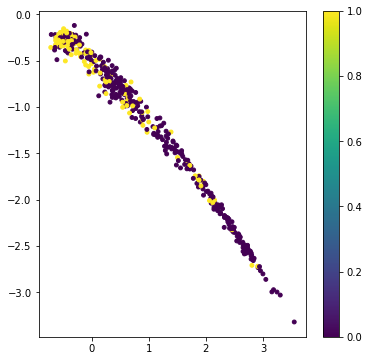

In [32]:
I=0
J=1
pl = plot_z_space(out2['mu'].detach().numpy(), sample_batch_test2["data_y"][:,5].detach().numpy(), I=I, J=J )

#pl.plot( MS_[I,:], MS_[J,:], 'C3', linewidth=5 );

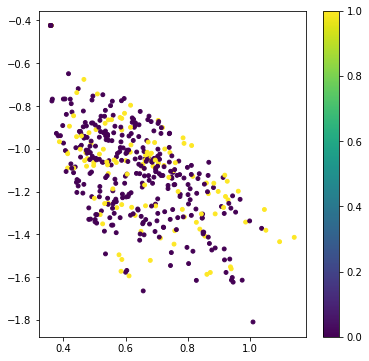

In [34]:
I=0
J=1
pl = plot_z_space(out2.mu_pred.detach().numpy(), out2.data_y_pred[:,5].detach().numpy(), I=I, J=J )

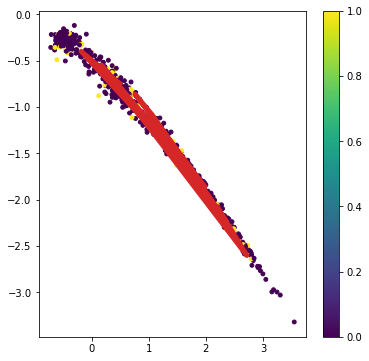

In [23]:
I=0
J=1
pl = plot_z_space(out2['mu'].detach().numpy(), res_matrix_y2[:,2].detach().numpy(), I=I, J=J )

pl.plot( MS_[I,:], MS_[J,:], 'C3', linewidth=5 );

In [49]:
non_missing_y_all = (1 - batch_test.missing_y * 1)
list_of_arrays_all = np.split(non_missing_y_all, np.cumsum(splits_y0[:-1]), axis=1)


In [37]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10)


z_embedded = torch.tensor(tsne.fit_transform(out2['z'].detach().numpy()))
# z_embedded_pred = z_embedded[len(out2['z_recon']):, :]
# z_embedded_rec =  z_embedded[:len(out2['z_recon']), :]

In [20]:
splits_flattened = [item + 1 for sublist in batch_test.num_for_rec for item in sublist]

In [21]:
l_ = np.cumsum([elem -1 for elem in batch_test.splits])

In [22]:
l_ = np.concatenate([np.array([0]), l_])

In [23]:
t = torch.split(z_embedded, splits_flattened, dim=0)
len(t)

431

In [24]:
z_embedded_grouped = [[t[l_[i]:l_[i+1]]] for i, elem in enumerate(l_[:-1])]

In [25]:
patient_index = 0
z_embedded_grouped[patient_index]


[(tensor([[ 38.2350, -18.7413],
          [-71.1137,   7.2708]]),
  tensor([[-11.4443, -11.6809],
          [  7.8730,  44.8633],
          [-69.1718, -29.5904]]),
  tensor([[ 12.0751, -44.1680],
          [  4.6501,  54.4452],
          [ 18.1598, -10.1976],
          [-82.4365, -21.8005]]),
  tensor([[ 14.5167, -17.9445],
          [ 16.9654,  25.1102],
          [ 21.8953, -49.9017],
          [ -0.6671,  30.6710],
          [-84.5401, -13.5831]]),
  tensor([[ 22.9948, -27.0371],
          [  4.1547,  53.5036],
          [ 54.4384, -28.3070],
          [-32.4233,  47.7729],
          [-50.2658,  46.9102],
          [-80.0442, -26.2520]]),
  tensor([[ 15.1293, -19.0028],
          [  5.2378,  51.6105],
          [ 70.4206, -13.1641],
          [-17.2782,  24.1292],
          [-40.9655,  46.2756],
          [-33.3539,  36.0261],
          [-69.9535, -27.0747]]))]

In [26]:
predicted_values = torch.stack([elem[-1] for elem in z_embedded_grouped[patient_index][0]])

In [27]:
reconstructed_values = z_embedded_grouped[patient_index][0][-1][:-1]

In [28]:
z_to_plot = torch.cat([elem[0][-1][:-1] for elem in z_embedded_grouped])

Text(tensor(-71.1137), tensor(-29.5904), 'start')

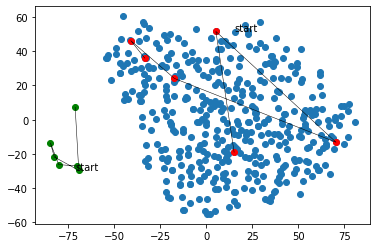

In [29]:
fig, ax = plt.subplots()
ax.scatter(z_to_plot[:,0], z_to_plot[:,1])
ax.scatter(reconstructed_values[:,0], reconstructed_values[:,1], c='r')
ax.scatter(predicted_values[:,0], predicted_values[:,1], c='g')
ax.plot(reconstructed_values[:,0], reconstructed_values[:,1], color='black', linewidth=0.5)
ax.plot(predicted_values[:,0], predicted_values[:,1], color='black', linewidth=0.5)
plt.text(reconstructed_values[0,0], reconstructed_values[1,1], 'start')
plt.text(predicted_values[0,0], predicted_values[1,1], 'start')



In [38]:
z_embedded_splitted = torch.split(z_embedded, batch_test.splits, dim=0)

In [39]:
z_embedded_pred = torch.stack([elem[-1,:] for elem in z_embedded_splitted])

In [40]:
z_embedded_rec = torch.cat([elem[:-1,:] for elem in z_embedded_splitted])

In [50]:
non_missing_y_all_splitted = torch.split(non_missing_y_all, batch_test.splits, dim=0)

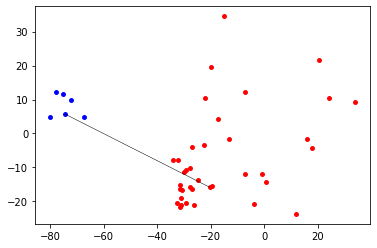

In [59]:
z_dim = 0
patient_index = 2
non_missing = torch.split(list_of_arrays_all[z_dim], batch_test.splits, dim = 0)[patient_index].all(axis=1)
p_0 = z_embedded_splitted[patient_index][non_missing, 0]
p_1 = z_embedded_splitted[patient_index][non_missing, 1]
indices = list_of_arrays_recon[z_dim].all(axis=1)
fig, ax = plt.subplots()
cmap = plt.cm.viridis
ax.scatter(z_embedded_rec[indices][:,0], z_embedded_rec[indices][:,1], facecolor = 'red', s=15)
indices = list_of_arrays_pred[z_dim].all(axis=1)
ax.scatter(z_embedded_pred[indices][:,0], z_embedded_pred[indices][:,1], facecolor = 'blue', s=15)
#ax.plot(z_embedded_splitted[1][:,0], z_embedded_splitted[1][:,1], color='black', linewidth=0.5)
ax.plot(p_0, p_1, color='black', linewidth=0.5)
# indices = list_of_arrays_all[0].all(axis=1)
# ax.scatter(z_embedded[:,0], z_embedded[:,1], facecolor='black', s=15)



In [58]:
torch.split(list_of_arrays_all[z_dim], batch_test.splits, dim = 0)

(tensor([[0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [1]]),
 tensor([[0],
         [1],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0]]),
 tensor([[1],
         [0],
         [0],
         [0],
         [0],
         [0]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]]),
 tensor([[0],
         [0],
         [0],
      

In [194]:
torch.split(list_of_arrays_all[1], batch_test.splits, dim = 0)[2]

tensor([[1, 1, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]])

In [161]:
torch.split(batch_test.missing_y, batch_test.splits, dim=0)[0]

tensor([[ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False]])

In [156]:
z_embedded_splitted[1][:,0]

tensor([ 12.9195,   6.0076, -17.2212,  -1.4954, -10.4789,  32.3057,  11.7317,
         30.6418,   7.3778])

<module 'matplotlib.pyplot' from '/home/cctrotte/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

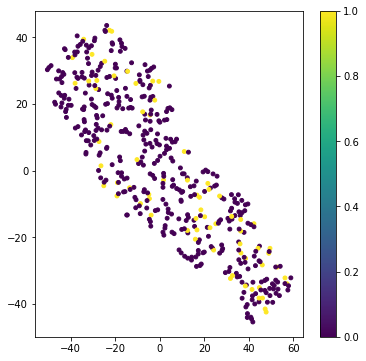

In [26]:
plot_z_space(z_embedded,  res_matrix_y2[:,2].detach().numpy(),  I=0, J=1)

<module 'matplotlib.pyplot' from '/home/cctrotte/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

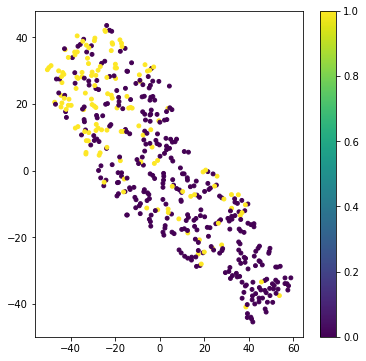

In [27]:
# sample_batch_test2["data_y"]
plot_z_space(z_embedded,  sample_batch_test2["data_y"][:,5].detach().numpy(),  I=0, J=1)